In [9]:
import torch
import numpy as np
from torch import nn
from torch import optim
import os

import torch.nn.functional as F
from torchvision import datasets ,transforms, models
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
from torch.autograd import Variable



In [10]:
data_dir= 'data/train2'

def load_split_train_test(datadir,valid_size=.2):
    # create a tranformation pipeline , all the images go 
    #under all the tranformations
    
    train_transforms=transforms.Compose([transforms.Resize((224,224)),transforms.ToTensor(),])
    test_transforms=transforms.Compose([transforms.Resize((224,224)),transforms.ToTensor(),])
    
    # callable funtions for loadeing data from image forlders,
    #apllying transformatioon
    train_data=  datasets.ImageFolder(datadir, transform=train_transforms)
    test_data=  datasets.ImageFolder(datadir,transform=test_transforms)
    
    # spliting train and test indices
    num_train= len(train_data)
    indices=list(range(num_train))
    split=int(np.floor(valid_size*num_train))
    
    np.random.shuffle(indices)
    from torch.utils.data.sampler import SubsetRandomSampler
    train_idx, test_idx=indices[split:],indices[:split]
    
    train_sampler= SubsetRandomSampler(train_idx)
    test_sampler= SubsetRandomSampler(test_idx)
    
    trainloader=torch.utils.data.DataLoader(train_data,sampler=train_sampler, 
                                            batch_size=64)
    testloader=torch.utils.data.DataLoader(test_data,sampler=train_sampler, 
                                            batch_size=64)
    
    return trainloader,testloader

trainloader,testloader=load_split_train_test(data_dir,.2)

print(trainloader.dataset.classes)

for batch_images, targets in trainloader:
    print(batch_images.shape)  # should be 32*3*224*224


    
    
    
    
    
    
    
    
    
    

['with_mask', 'without_mask']
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([37, 3, 224, 224])


In [11]:
# check if gpu is present or not 
device=torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
model= models.resnet50(pretrained=True)
print(model)



cuda
ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride

)


In [12]:
os.environ['CUDA_LAUNCH_BLOCKING']='0'
torch.cuda.get_device_name(torch.cuda.current_device())
torch.cuda.set_device(0)

In [13]:
for param in model.parameters():
    param.requires_grad=False
# New layer for classification
model.fc=nn.Sequential(nn.Linear(2048,512),
                       nn.ReLU(),
                       nn.Dropout(0.2),
                       nn.Linear(512,10),
                       nn.LogSoftmax(dim=1))

criterion=nn.NLLLoss()
optimizer=optim.Adam(model.fc.parameters(),lr=0.003)

model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [15]:

epochs=10
steps=0

running_loss=0

print_every=10

train_losses,test_losses=[],[]

for epoch in range(epochs):
    for inputs,labels in trainloader:
        steps+=1
        inputs,labels=inputs.to(device),labels.to(device)
        optimizer.zero_grad()
        logps=model.forward(inputs)
        loss=criterion(logps,labels)
        loss.backward()
        optimizer.step()
        running_loss+=loss.item()
        
        if steps%print_every==0:
            test_loss=0
            accuracy=0
            for inputs,labels in testloader:
                inputs,labels=inputs.to(device),labels.to(device)
                logps=model.forward(inputs)
                batch_loss=criterion(logps,labels)
                test_loss += batch_loss.item()
                ps=torch.exp(logps)
                
                top_p,top_class=ps.topk(1,dim=1)
                equals= top_class==labels.view(*top_class.shape)
                accuracy+=torch.mean(equals.type(torch.FloatTensor)).item()
            train_losses.append(running_loss/len(trainloader))
            test_losses.append(test_loss/len(testloader))
            
            print(f"Epoch {epoch+1}/{epochs}.. "
                  f"Train loss: {running_loss/print_every:.3f}.. "
                  f"Test loss: {test_loss/len(testloader):.3f}.. "
                  f"Test accuracy: {accuracy/len(testloader):.3f}")
            running_loss=0
            model.train()
            
    if epoch%2==0:
        print("Saving Model after " +str(epoch) +" epochs")
        torch.save(model,'classifymodel_6.pth')

torch.save(model,'classifymodel_6.pth')
            

Epoch 1/10.. Train loss: 0.755.. Test loss: 0.434.. Test accuracy: 0.821
Saving Model after 0 epochs
Epoch 2/10.. Train loss: 0.250.. Test loss: 0.054.. Test accuracy: 0.985
Epoch 2/10.. Train loss: 0.111.. Test loss: 0.065.. Test accuracy: 0.978
Epoch 3/10.. Train loss: 0.081.. Test loss: 0.056.. Test accuracy: 0.982
Epoch 3/10.. Train loss: 0.073.. Test loss: 0.048.. Test accuracy: 0.983
Saving Model after 2 epochs
Epoch 4/10.. Train loss: 0.036.. Test loss: 0.054.. Test accuracy: 0.982
Epoch 4/10.. Train loss: 0.043.. Test loss: 0.029.. Test accuracy: 0.993
Epoch 5/10.. Train loss: 0.026.. Test loss: 0.029.. Test accuracy: 0.989
Epoch 5/10.. Train loss: 0.036.. Test loss: 0.043.. Test accuracy: 0.985
Saving Model after 4 epochs
Epoch 6/10.. Train loss: 0.022.. Test loss: 0.025.. Test accuracy: 0.992
Epoch 7/10.. Train loss: 0.024.. Test loss: 0.025.. Test accuracy: 0.989
Epoch 7/10.. Train loss: 0.028.. Test loss: 0.031.. Test accuracy: 0.990
Saving Model after 6 epochs
Epoch 8/10..

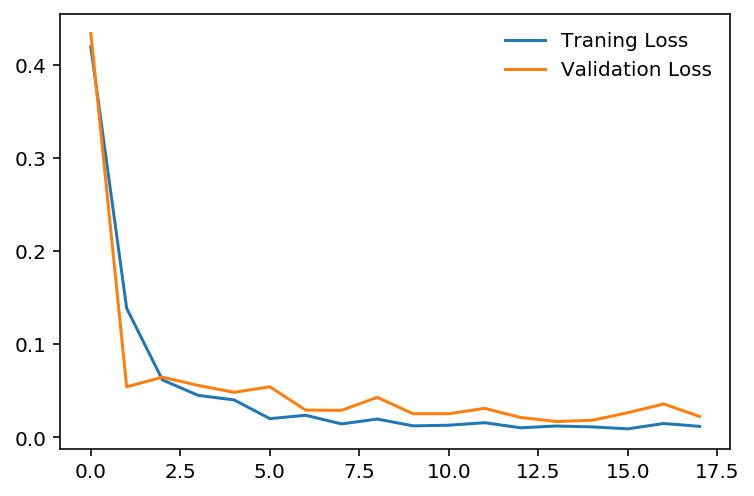

In [16]:
plt.plot(train_losses,label='Traning Loss')
plt.plot(test_losses,label='Validation Loss')

plt.legend(frameon=False)
plt.show()
